In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url, untar=True, cache_dir=".", cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb_v1")

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 40s 0us/step


In [3]:
train_dir = os.path.join(dataset_dir, "./aclImdb/train")
os.listdir(train_dir)

['pos',
 'neg',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsup',
 'urls_pos.txt',
 'unsupBow.feat',
 'urls_unsup.txt']

In [4]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [5]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "./aclImdb_v1/aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [6]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2025-06-29 21:55:51.182673: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "./aclImdb_v1/aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "./aclImdb_v1/aclImdb/test", batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [9]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [ ]:
max_features = 10000
sequence_length = 250

# 단어 → 정수 인덱스 시퀀스로 변환
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [11]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2025-06-29 21:55:54.896326: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [14]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
# 성능 최적화를 위한 설정
AUTOTUNE = tf.data.AUTOTUNE

# cache: 작은 데이터셋이나 짧은 epoch 반복일 때 매우 유효
# prefetch: 다음 배치를 백그라운드에서 미리 준비
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
embedding_dim = 16

model = tf.keras.Sequential(
    [
        layers.Embedding(max_features + 1, embedding_dim), # 정수 to 실수
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(), # 시퀀스 차원(문장길이)을 평균내어 하나의 벡터로 축소
        layers.Dropout(0.2),
        layers.Dense(1),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)],
)

In [19]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.5878 - loss: 0.6812 - val_binary_accuracy: 0.7416 - val_loss: 0.6117
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - binary_accuracy: 0.7567 - loss: 0.5781 - val_binary_accuracy: 0.8174 - val_loss: 0.4954
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8194 - loss: 0.4666 - val_binary_accuracy: 0.8368 - val_loss: 0.4242
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8495 - loss: 0.3947 - val_binary_accuracy: 0.8486 - val_loss: 0.3813
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8674 - loss: 0.3493 - val_binary_accuracy: 0.8568 - val_loss: 0.3550
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8820 - loss: 0.3163 - val_binary_accuracy: 0.8630 - val_loss: 0.3342
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.8896 - loss: 0.2923 - val_binary_accuracy: 0.8660 - val_loss: 0.3224
Epoch 

In [20]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8646 - loss: 0.3239
Loss:  0.323249489068985
Accuracy:  0.8642799854278564


In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

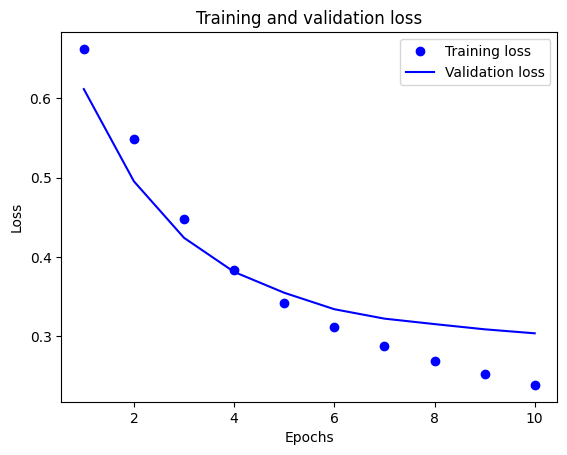

In [22]:
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, "bo", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

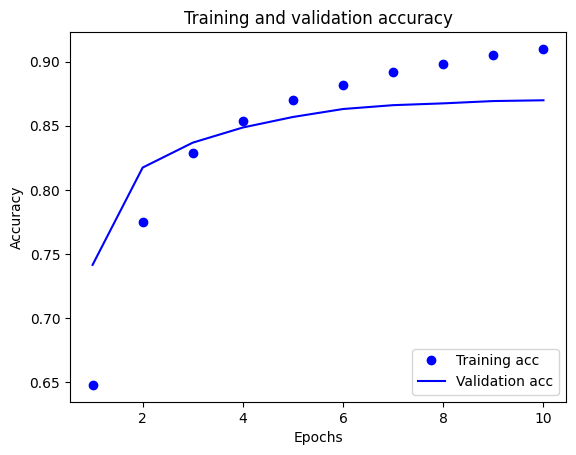

In [23]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()

In [ ]:
# 최종 추론 모델
# 문장을 그래도 받아서 추론하는 최종 형태의 모델
export_model = tf.keras.Sequential(
    [vectorize_layer, model, layers.Activation("sigmoid")]
)

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"],
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8649 - loss: 0.3230
0.8642799854278564


In [28]:
import numpy as np

examples = ["The movie was great!", "The movie was okay.", "The movie was terrible..."]

export_model.predict(np.array(examples, dtype=object))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


array([[0.42863408],
       [0.26285067],
       [0.19389726]], dtype=float32)